# 10.5 Infuence Functions and Robust Estimation

### Setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
leukemia = pd.read_csv("../data/leukemia_big.csv")

In [4]:
leukemia.head()

,ALL,ALL.1,ALL.2,ALL.3,ALL.4,ALL.5,ALL.6,ALL.7,ALL.8,ALL.9,...,AML.15,AML.16,AML.17,AML.18,AML.19,AML.20,AML.21,AML.22,AML.23,AML.24
0,-1.533622,-0.867610,-0.433172,-1.671903,-1.187689,-1.127234,-1.045409,-0.106917,-1.198796,-1.190899,...,-0.436650,-1.274708,-0.681458,-0.876610,-0.624022,-0.431628,-1.435259,-0.671954,-1.013161,-0.969482
1,-1.235673,-1.275501,-1.184492,-1.596424,-1.335256,-1.113730,-0.800880,-0.745177,-0.849312,-1.190899,...,-0.915483,-1.354363,-0.653559,-1.096250,-1.066594,-1.335256,-1.204586,-0.751457,-0.889592,-1.080988
2,-0.333983,0.375927,-0.459196,-1.422571,-0.797493,-1.362768,-0.671954,-1.175674,0.320813,0.646610,...,-0.736156,-0.022153,-0.037455,-0.567335,-1.100749,-0.552938,-0.948874,-0.231657,-0.742163,-0.779500
3,0.488702,0.444011,0.436264,0.193353,0.235632,-0.360312,0.184941,0.425653,0.333983,0.235270,...,0.083781,0.356562,0.416241,0.533986,0.227505,0.416816,0.408202,0.326556,0.361813,0.298864
4,-1.300893,-1.229660,-1.325882,-1.818329,-1.311206,-1.513975,-1.651624,-1.339555,-0.593132,0.133302,...,-1.547444,-1.264475,-1.512318,-1.469583,-1.283472,-0.977672,-1.090178,-1.545120,-1.174272,-1.443183


In [5]:
all_cols = [col for col in leukemia.columns if col.startswith("ALL")]
all_scores = leukemia[all_cols].iloc[135].values

### Figure 10.7

In [6]:
def trimmed_influence(data, alpha):
    q_lo, q_hi = np.quantile(data, q=(alpha, 1 - alpha))
    wmean = np.clip(data, q_lo, q_hi).mean()
    def fn(x):
        return (np.clip(x, q_lo, q_hi) - wmean) / (1 - 2 * alpha)
    return fn

In [7]:
inffn2 = trimmed_influence(all_scores, 0.2)
inffn4 = trimmed_influence(all_scores, 0.4)

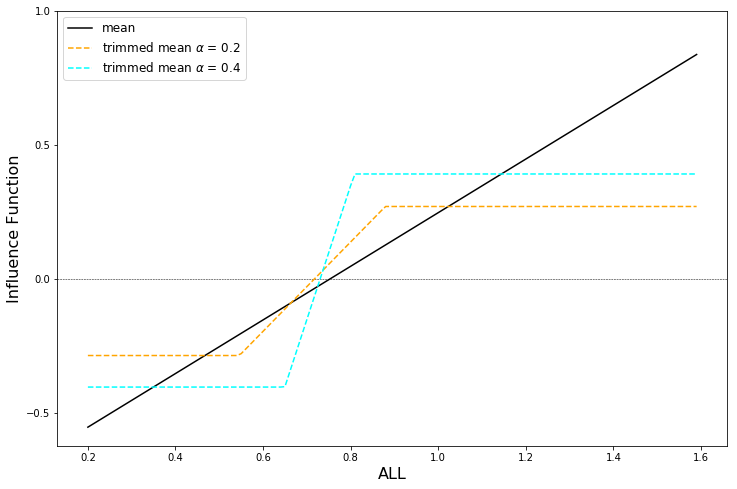

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

xvals = np.arange(0.2, 1.6, 0.01)

ax.axhline(0, c="k", linestyle="--", linewidth=0.5)

ax.plot(xvals, [x - all_scores.mean() for x in xvals], c="k", label="mean")
ax.plot(xvals, [inffn2(x) for x in xvals], c="orange", linestyle="--", label="trimmed mean $\\alpha$ = 0.2")
ax.plot(xvals, [inffn4(x) for x in xvals], c="cyan", linestyle="--", label="trimmed mean $\\alpha$ = 0.4")

ax.legend(fontsize=12)

ax.set_yticks([-0.5, 0, 0.5, 1.0])

ax.set_xlabel("ALL", size=16)
ax.set_ylabel("Influence Function", size=16);

This looks pretty similar to the book's figure, but here the lines seem to not meet up as much when crossing y=0.

### Table 10.3

In [9]:
def trimmed_mean(data, alpha):
    if alpha == 0.5:
        return np.median(data)
    q_lo, q_hi = np.quantile(data, q=(alpha, 1 - alpha))
    return data[(data >= q_lo) & (data <= q_hi)].mean()

In [10]:
alphas = np.array(list(range(6))) / 10
alphas

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

#### Means

In [11]:
means = [trimmed_mean(all_scores, alpha) for alpha in alphas]

#### Bootstrap

In [12]:
n_obs = all_scores.shape[0]
n_boots = 1000
bootvals = np.zeros((6, n_boots))
for b in range(n_boots):
    bootdata = np.random.choice(all_scores, size=n_obs, replace=True)
    for i, alpha in enumerate(alphas):
        bootvals[i, b] = trimmed_mean(bootdata, alpha)

In [13]:
sds = np.sqrt(bootvals.var(ddof=1, axis=1))

#### Table

In [14]:
index = pd.MultiIndex.from_arrays(
    [["Mean"] * 5 + ["Median"], alphas],
    names=(None, "Trim")
)

table = pd.DataFrame(
    {"Trimmed mean": means, "Bootstrap sd": sds},
    index=index,
)

In [15]:
table.round(3)

Trimmed mean  Bootstrap sd
       Trim                            
Mean   0.0          0.752         0.040
       0.1          0.726         0.039
       0.2          0.720         0.037
       0.3          0.725         0.042
       0.4          0.735         0.050
Median 0.5          0.733         0.054

TO DO: include the influence function standard errors